Using device: cpu


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_37691/3503717286.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

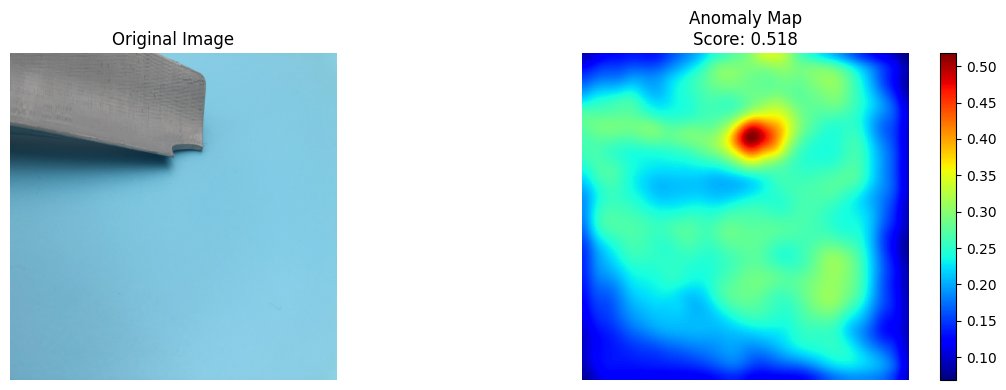

Anomaly Score: 0.518
Is Anomaly: True


In [6]:
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


# Import your model classes - adjust these imports based on your project structure
import sys
sys.path.append('./')  
from models.MMR.MMR import MMR_base
from models.MMR.utils import ForwardHook, cal_anomaly_map
from config import get_cfg

def detect_single_image(image_path, checkpoint_path, config_path, threshold=0.4):
    """
    Detect anomalies in a single image using the AeBAD model
    
    Args:
        image_path (str): Path to the input image
        checkpoint_path (str): Path to the model checkpoint
        config_path (str): Path to the model configuration file
        threshold (float): Anomaly detection threshold (0-1)
        
    Returns:
        dict: Detection results including anomaly score, map, and visualization
    """
    # Load configuration
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize current model (WideResNet50)
    cur_model = models.wide_resnet50_2(pretrained=True)
    cur_model.to(device)
    cur_model.eval()
    
    # Initialize MMR model
    mmr_model = MMR_base(cfg=cfg)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    mmr_model.load_state_dict(checkpoint['mmr_base_state_dict'])
    mmr_model.to(device)
    mmr_model.eval()
    
    # Register hooks
    teacher_outputs_dict = {}
    for extract_layer in cfg.TRAIN.MMR.layers_to_extract_from:
        forward_hook = ForwardHook(teacher_outputs_dict, extract_layer)
        network_layer = cur_model.__dict__["_modules"][extract_layer]
        network_layer[-1].register_forward_hook(forward_hook)
    
    # Define image transforms
    transform = transforms.Compose([
        transforms.Resize(cfg.DATASET.resize),
        transforms.CenterCrop(cfg.DATASET.imagesize),
        transforms.ToTensor(),
    ])
    
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Get current model features
        teacher_outputs_dict.clear()
        _ = cur_model(image_tensor)
        multi_scale_features = [teacher_outputs_dict[key] 
                              for key in cfg.TRAIN.MMR.layers_to_extract_from]
        
        # Get MMR features
        reverse_features = mmr_model(image_tensor, 
                                   mask_ratio=cfg.TRAIN.MMR.test_mask_ratio)
        multi_scale_reverse_features = [reverse_features[key] 
                                      for key in cfg.TRAIN.MMR.layers_to_extract_from]
        
        # Calculate anomaly map
        anomaly_map, _ = cal_anomaly_map(
            multi_scale_features, 
            multi_scale_reverse_features, 
            image_tensor.shape[-1],
            amap_mode='a'
        )
        
        # Apply Gaussian smoothing
        anomaly_map = gaussian_filter(anomaly_map[0], sigma=4)
        
        # Calculate final results
        anomaly_score = np.max(anomaly_map)
        is_anomaly = anomaly_score > threshold
        
        # Clear any existing plots
        plt.clf()
        
        # Create new figure with specified DPI for better resolution
        fig = plt.figure(figsize=(12, 4), dpi=100)
        
        # Plot original image
        ax1 = plt.subplot(1, 2, 1)
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot anomaly map
        ax2 = plt.subplot(1, 2, 2)
        im = ax2.imshow(anomaly_map, cmap='jet')
        ax2.set_title(f"Anomaly Map\nScore: {anomaly_score:.3f}")
        ax2.axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=ax2)
        
        # Adjust layout and display
        plt.tight_layout()
        
        # For Jupyter notebook
        plt.show()
        
        return {
            'anomaly_score': float(anomaly_score),
            'anomaly_map': anomaly_map,
            'is_anomaly': bool(is_anomaly),
            'figure': fig  # Return the figure object for further manipulation if needed
        }

# Example usage

    # Replace these paths with your actual paths
image_path = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test/fracture/view/IMG_9596.png"
checkpoint_path = "checkpoints/aebad_S_AeBAD_S_MMR_model.pth"
config_path = "method_config/AeBAD_S/MMR.yaml"

# Run detection
result = detect_single_image(image_path, checkpoint_path, config_path)

# Print results
print(f"Anomaly Score: {result['anomaly_score']:.3f}")
print(f"Is Anomaly: {result['is_anomaly']}")

In [4]:
import os
import base64
from groq import Groq

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Initialize the Groq client with your API key
client = Groq(api_key="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")

# Class labels
class_labels = ["ablation", "breakdown", "fracture", "groove", "good"]

# Function to classify the image and return the predicted class
def classify_image(image_path):
    try:
        # Encode the image to base64
        base64_image = encode_image(image_path)

        # Modified prompt to get cleaner output
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": (
                            "I am analyzing images of aircraft engine blades. Please classify the image into one of the following categories based on visible damage: "
                            "1. **Ablation**: Loss of material due to erosion or wear, usually represented by blackened or scorched areas, typically seen as small regions of surface damage."
                            "2. **Breakdown**: Holes or significant damage in the blade structure, indicating severe stress or material failure."
                            "3. **Fracture**: Loss or cutting out of part of the blade, usually seen as cracks or chunks missing from the edges."
                            "4. **Groove**: Shallow cuts or indentations along the surface of the blade, often caused by external factors or friction."
                            "5. **Good**: No visible damage, wear, or defects, with the blade in perfect working condition."
                            "Classify this aircraft engine blade image into exactly one of these categories: ablation, breakdown, fracture, groove, good. "
                            "Respond with only the category name in lowercase, nothing else."
                        )},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                            },
                        },
                    ],
                }
            ],
            model="llama-3.2-90b-vision-preview",
        )

        # Get and clean the prediction
        prediction = chat_completion.choices[0].message.content.lower().strip()
        # Ensure prediction is one of our valid classes
        return prediction if prediction in class_labels else None

    except Exception as e:
        print(f"Error with image {image_path}: {e}. Skipping this image.")
        return None

# Example usage for a single image

# Path to the input image
image_path = "/Users/prashantronad/Documents/College/5thsemEL/AeBAD/AeBAD_S/test/fracture/view/IMG_9596.png"  # Replace with your image path

# Classify the image
predicted_label = classify_image(image_path)

if predicted_label:
    print(f"Predicted class for the image: {predicted_label}")
else:
    print("Failed to classify the image.")


Predicted class for the image: fracture
